## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import zero_one_loss
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier       # Used in 2D data problems
from sklearn.linear_model import LogisticRegression  # Used in MNIST data problem
from sklearn.linear_model import LogisticRegressionCV
import torch

seed = 1234
np.random.seed(seed) 

## Loading and Scaling Data

In [4]:
# 1. Setup the paths
base_path = "." 
images_folder = os.path.join(base_path, "images")
csv_file = os.path.join(base_path, "legend.csv")

# 2. Read CSV file
df = pd.read_csv(csv_file)

# Lists to store our data
data = []   # This will become X
labels = [] # This will become y

# Define a fixed size for images. For example, MINST is 28*28, here we do 64*64 
IMG_SIZE = 64

print("Loading images... this might take a moment.")

# 3. Loop through the CSV and load images
for index, row in df.iterrows():
    img_name = row['image']
    emotion = row['emotion']

    img_path = os.path.join(images_folder, img_name)

    # Check if file actually exists to avoid errors
    if os.path.exists(img_path):
        # Load image in Grayscale (usually sufficient for emotion detection)
        # If you want color, remove the second argument.
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img_array is not None:
            # Resize the image (Crucial step!)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            
            # Flatten the image
            # This converts the 2D image (64x64) into a 1D row of numbers (4096,)
            # This matches the format your professor used for X
            flat_array = new_array.flatten()
            
            data.append(flat_array)
            labels.append(emotion)

# 4. Convert to Numpy Arrays (X and y)
X = np.array(data)
y = np.array(labels)

print("Data loaded successfully!")
print(f"Features (X) shape: {X.shape}") # Should be (Number of images, 4096)
print(f"Labels (y) shape: {y.shape}")    # Should be (Number of images,)


Loading images... this might take a moment.
Data loaded successfully!
Features (X) shape: (13690, 4096)
Labels (y) shape: (13690,)


## Data Exploration and Visualization

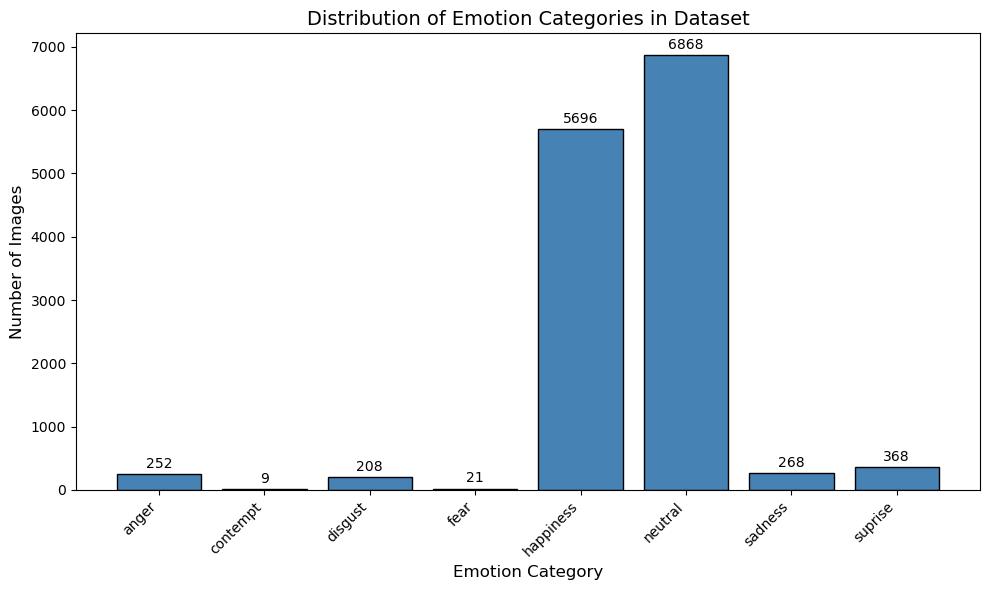


=== Dataset Summary ===
Total number of images: 13690
Number of emotion categories: 8

Class distribution:
  anger: 252 (1.8%)
  contempt: 9 (0.1%)
  disgust: 208 (1.5%)
  fear: 21 (0.2%)
  happiness: 5696 (41.6%)
  neutral: 6868 (50.2%)
  sadness: 268 (2.0%)
  suprise: 368 (2.7%)


In [5]:
# 1. Class Distribution - Bar Chart
emotion_counts = pd.Series(y).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(emotion_counts.index, emotion_counts.values, color='steelblue', edgecolor='black')
ax.set_xlabel('Emotion Category', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Distribution of Emotion Categories in Dataset', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, emotion_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Dataset Summary ===")
print(f"Total number of images: {len(y)}")
print(f"Number of emotion categories: {len(emotion_counts)}")
print(f"\nClass distribution:")
for emotion, count in emotion_counts.items():
    percentage = count / len(y) * 100
    print(f"  {emotion}: {count} ({percentage:.1f}%)")

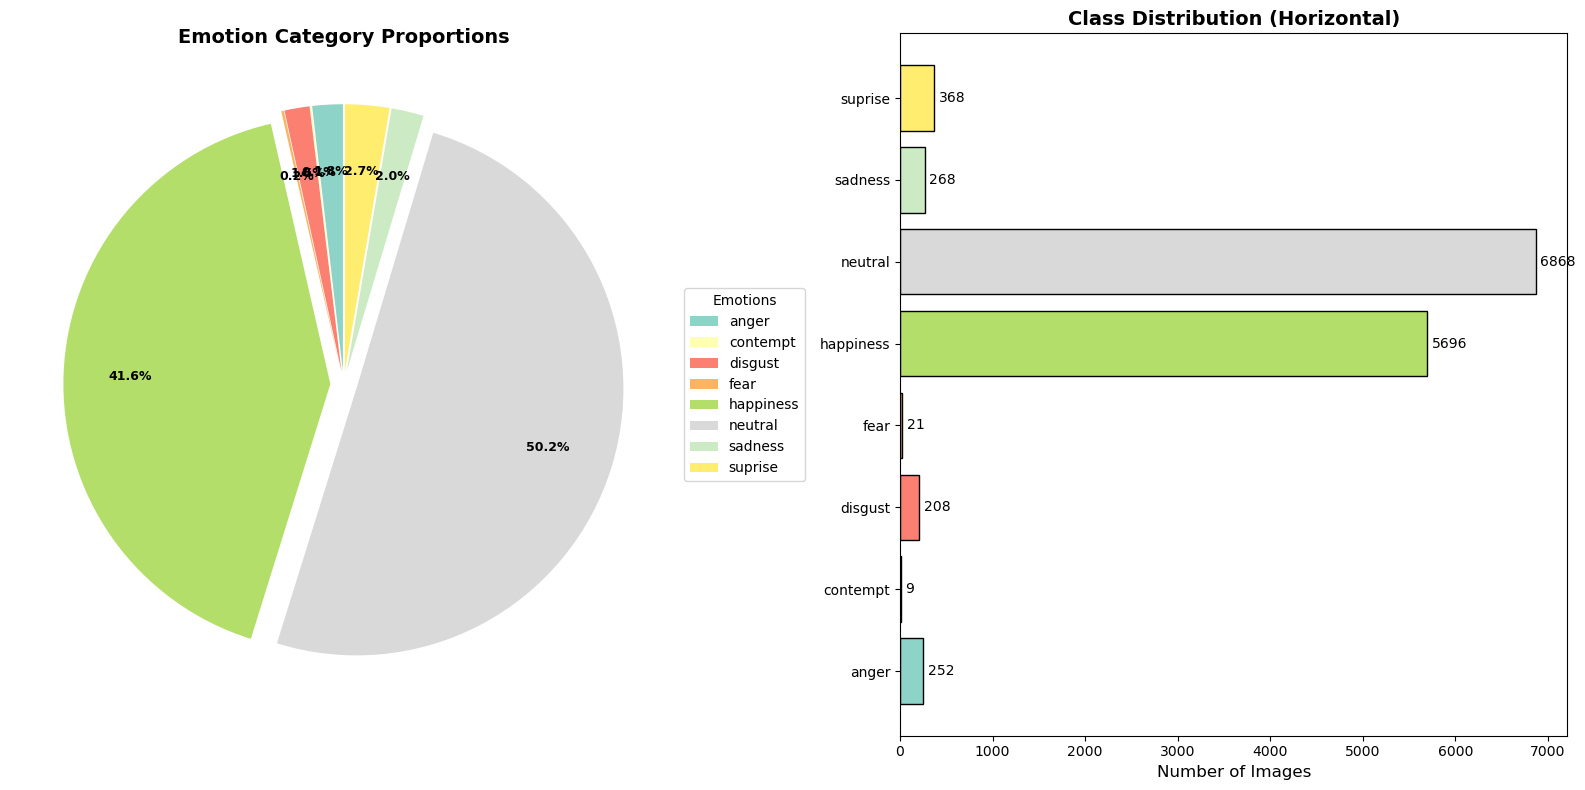


=== Class Imbalance Analysis ===
Largest class: neutral with 6868 samples
Smallest class: contempt with 9 samples
Imbalance ratio (max/min): 763.11x


In [6]:
# 2. Class Imbalance Visualization - Pie Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart - improved readability
colors = plt.cm.Set3(np.linspace(0, 1, len(emotion_counts)))

# Use legend instead of labels directly on pie for cleaner look
wedges, texts, autotexts = axes[0].pie(emotion_counts.values, 
                                        autopct='%1.1f%%', 
                                        colors=colors, 
                                        startangle=90,
                                        explode=[0.05] * len(emotion_counts),
                                        pctdistance=0.75)

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

# Add legend outside the pie chart for clarity
axes[0].legend(wedges, emotion_counts.index, title="Emotions", 
               loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)
axes[0].set_title('Emotion Category Proportions', fontsize=14, fontweight='bold')

# Horizontal bar chart for better comparison
y_pos = np.arange(len(emotion_counts))
axes[1].barh(y_pos, emotion_counts.values, color=colors, edgecolor='black')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(emotion_counts.index)
axes[1].set_xlabel('Number of Images', fontsize=12)
axes[1].set_title('Class Distribution (Horizontal)', fontsize=14, fontweight='bold')

# Add count labels - renamed loop variable to avoid shadowing 'y'
for idx, (count, pos) in enumerate(zip(emotion_counts.values, y_pos)):
    axes[1].text(count + 50, pos, str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
max_class = emotion_counts.max()
min_class = emotion_counts.min()
print(f"\n=== Class Imbalance Analysis ===")
print(f"Largest class: {emotion_counts.idxmax()} with {max_class} samples")
print(f"Smallest class: {emotion_counts.idxmin()} with {min_class} samples")
print(f"Imbalance ratio (max/min): {max_class/min_class:.2f}x")

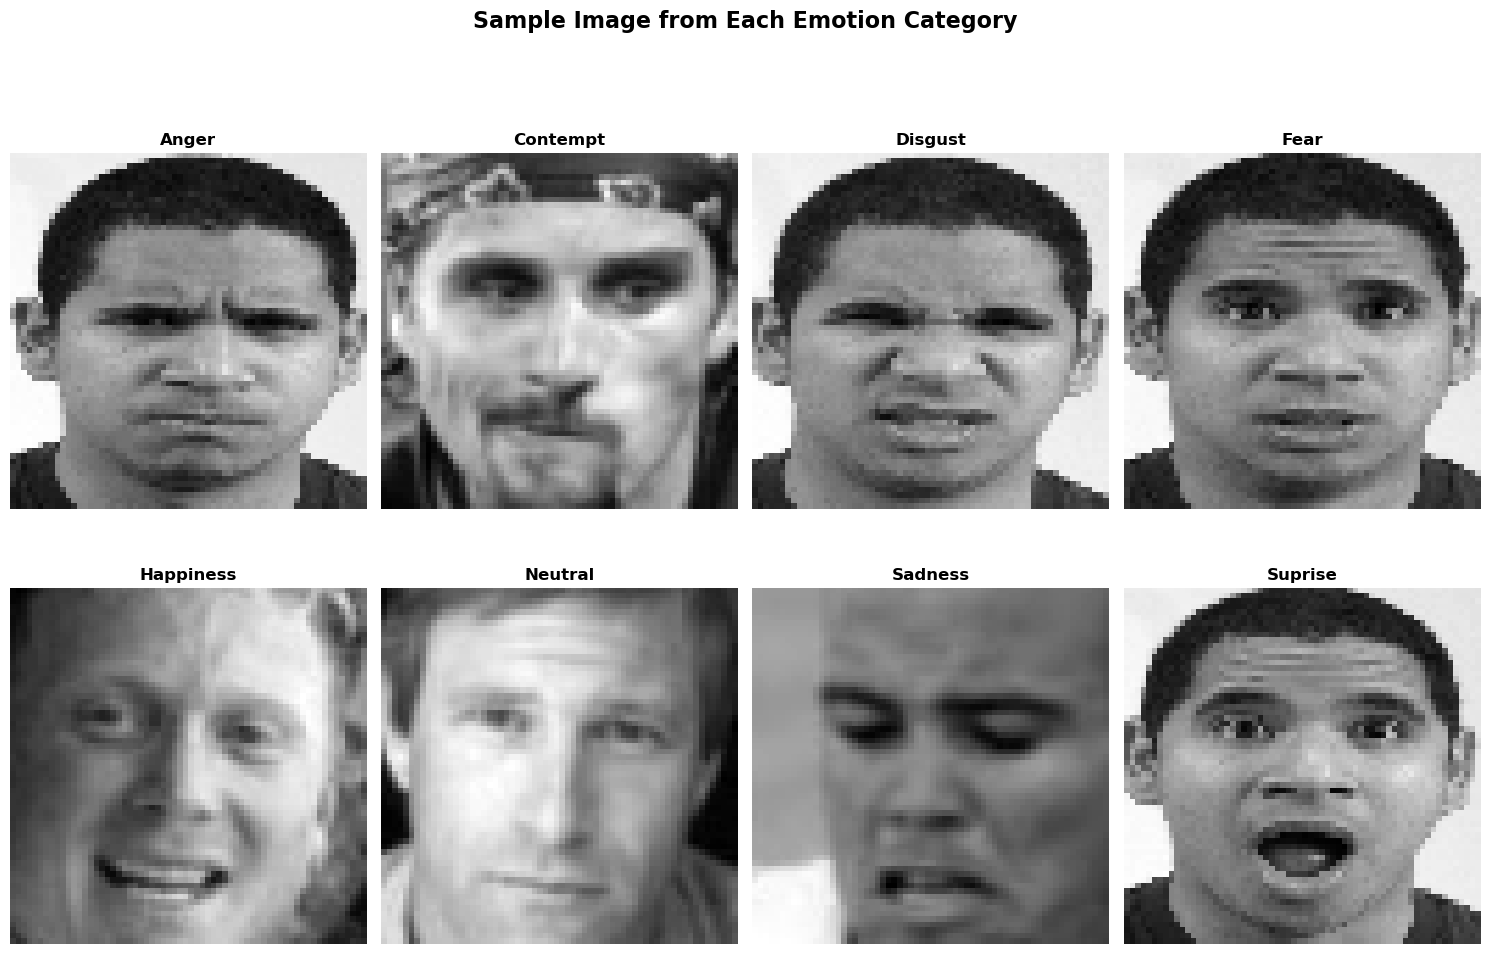

In [7]:
# 3. Sample Image from Each Emotion Category
unique_emotions = np.unique(y)
n_emotions = len(unique_emotions)

# Create a grid to display one sample from each emotion
fig, axes = plt.subplots(2, (n_emotions + 1) // 2, figsize=(15, 10))
axes = axes.flatten()

for i, emotion in enumerate(unique_emotions):
    # Get first image of this emotion
    idx = np.where(y == emotion)[0][0]
    axes[i].imshow(X[idx].reshape(64, 64), cmap='gray')
    axes[i].set_title(f'{emotion.capitalize()}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

# Hide any extra subplots
for j in range(len(unique_emotions), len(axes)):
    axes[j].axis('off')

plt.suptitle('Sample Image from Each Emotion Category', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

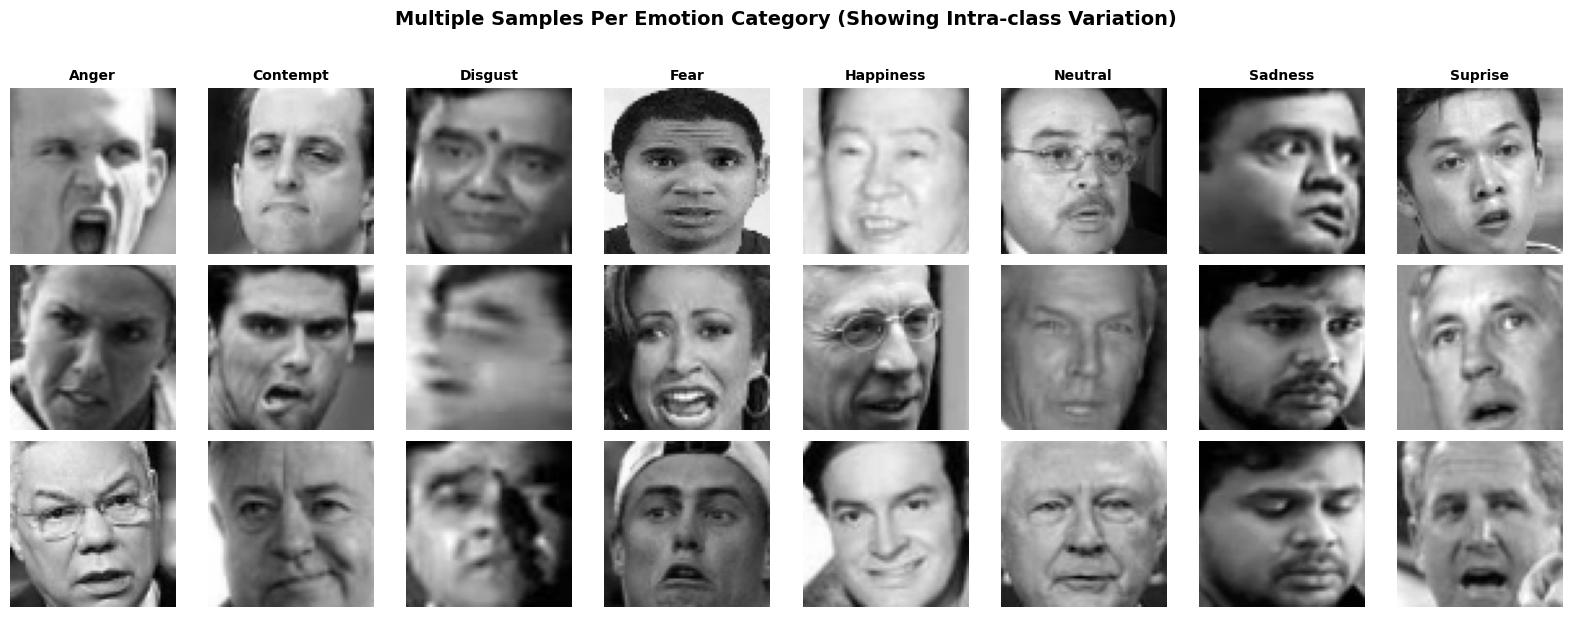

In [8]:
# 4. Multiple Samples Per Emotion (3x8 grid showing variety within each class)
n_samples_per_class = 3

fig, axes = plt.subplots(n_samples_per_class, n_emotions, figsize=(16, 6))

for j, emotion in enumerate(unique_emotions):
    # Get indices for this emotion
    emotion_indices = np.where(y == emotion)[0]
    # Randomly select samples (or take first few if not enough)
    n_available = min(n_samples_per_class, len(emotion_indices))
    sample_indices = np.random.choice(emotion_indices, n_available, replace=False)
    
    for i in range(n_samples_per_class):
        if i < n_available:
            axes[i, j].imshow(X[sample_indices[i]].reshape(64, 64), cmap='gray')
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(emotion.capitalize(), fontsize=10, fontweight='bold')

plt.suptitle('Multiple Samples Per Emotion Category (Showing Intra-class Variation)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

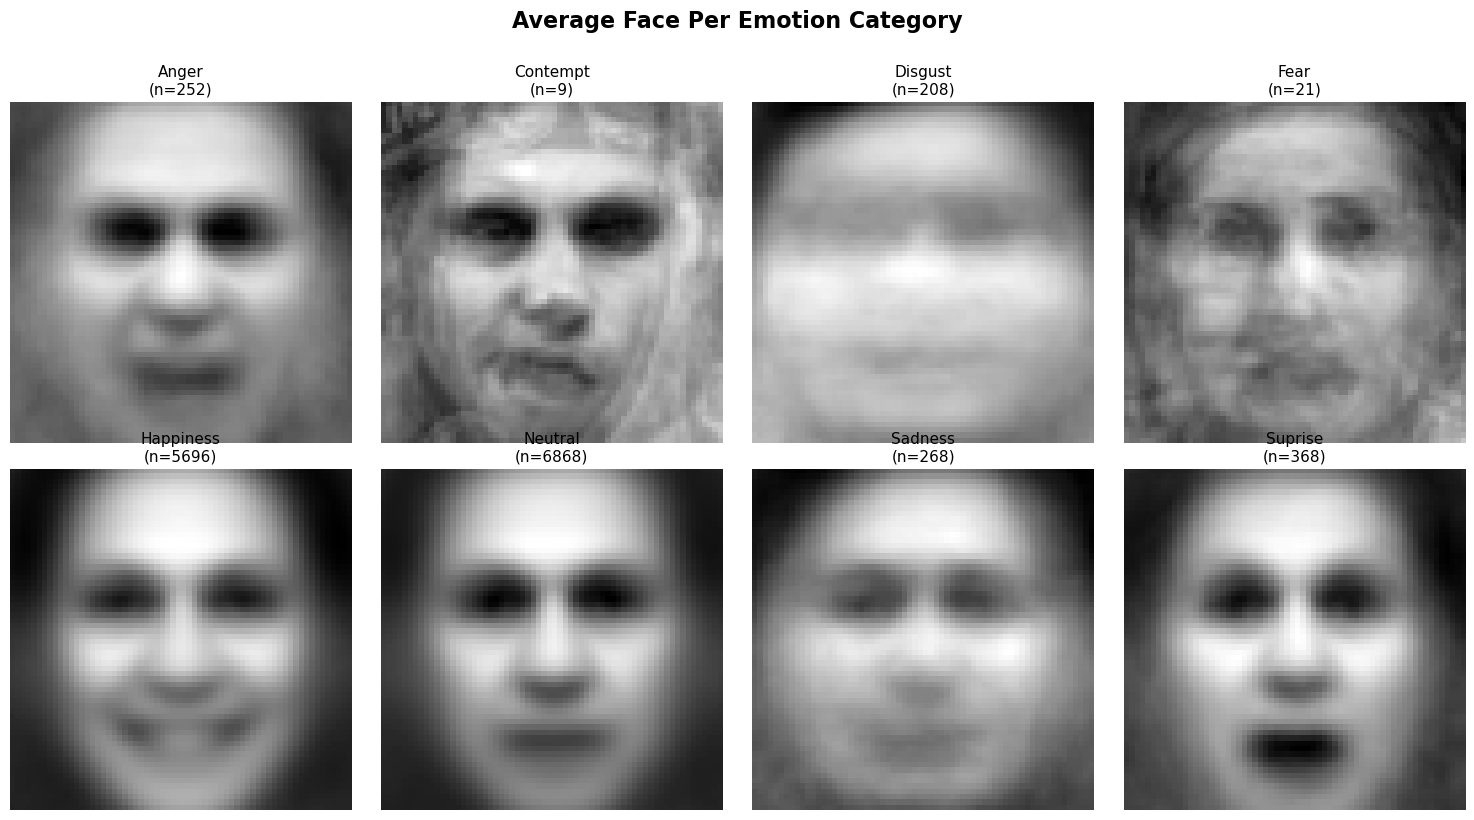

In [9]:
# 5. Average Face per Emotion Category
fig, axes = plt.subplots(2, (n_emotions + 1) // 2, figsize=(15, 8))
axes = axes.flatten()

for i, emotion in enumerate(unique_emotions):
    # Calculate mean face for this emotion
    emotion_images = X[y == emotion]
    mean_face = emotion_images.mean(axis=0).reshape(64, 64)
    
    axes[i].imshow(mean_face, cmap='gray')
    axes[i].set_title(f'{emotion.capitalize()}\n(n={len(emotion_images)})', fontsize=11)
    axes[i].axis('off')

# Hide any extra subplots
for j in range(len(unique_emotions), len(axes)):
    axes[j].axis('off')

plt.suptitle('Average Face Per Emotion Category', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Training Data Splitting

In [11]:
# Split strategy: 70% train, 15% validation, 15% test
# Using stratified sampling to maintain class proportions (for imbalanced "disgust" class)

# First split: 70% train, 30% temp (which will become val + test)
X_tr, X_temp, y_tr, y_temp = train_test_split(
    X, y, 
    test_size=0.30,           # 30% goes to temp
    random_state=seed, 
    shuffle=True,
    stratify=y                # Maintain class proportions!
)

# Second split: Split the 30% temp into 50/50 -> 15% val, 15% test
X_val, X_te, y_val, y_te = train_test_split(
    X_temp, y_temp, 
    test_size=0.50,           # 50% of 30% = 15% of original
    random_state=seed, 
    shuffle=True,
    stratify=y_temp           # Maintain class proportions!
)

print(f"=== Data Split Summary ===")
print(f"Training set:   {X_tr.shape[0]:,} samples ({X_tr.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_te.shape[0]:,} samples ({X_te.shape[0]/len(X)*100:.1f}%)")
print(f"Total:          {len(X):,} samples")

# Verify stratification worked - check class distribution in each split
print(f"\n=== Class Distribution Verification ===")
for name, labels in [("Train", y_tr), ("Validation", y_val), ("Test", y_te)]:
    counts = pd.Series(labels).value_counts()
    min_class = counts.min()
    print(f"{name}: min class has {min_class} samples ('{counts.idxmin()}')")

# Scaling - fit ONLY on training data, transform all sets
scaler = StandardScaler()
scaler.fit(X_tr)                      # Fit only on training data
X_tr = scaler.transform(X_tr)         # Transform training
X_val = scaler.transform(X_val)       # Transform validation  
X_te = scaler.transform(X_te)         # Transform test

=== Data Split Summary ===
Training set:   9,583 samples (70.0%)
Validation set: 2,053 samples (15.0%)
Test set:       2,054 samples (15.0%)
Total:          13,690 samples

=== Class Distribution Verification ===
Train: min class has 6 samples ('contempt')
Validation: min class has 2 samples ('contempt')
Test: min class has 1 samples ('contempt')


## Logistic Regression Model

### Hyperparameter Search via Cross-Validation
We'll search over several hyperparameters:
- **C**: Regularization strength (inverse). Smaller = stronger regularization
- **penalty**: Type of regularization ('l1' for Lasso, 'l2' for Ridge)
- **solver**: Optimization algorithm (must be compatible with penalty choice)

We use 5-fold cross-validation on the training data, then evaluate the best models on the validation set.

In [14]:
from sklearn.model_selection import cross_val_score
import time

# Define hyperparameter grid
# C values: range from strong regularization (0.001) to weak regularization (100)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Penalty and solver combinations (must be compatible)
# - 'l2' works with: 'lbfgs', 'newton-cg', 'sag', 'saga'
# - 'l1' works with: 'saga', 'liblinear'
penalty_solver_combos = [
    ('l2', 'lbfgs'),      # L2 regularization with LBFGS (default, good for multiclass)
    # ('l2', 'saga'),       # L2 with SAGA (supports all penalties, good for large datasets)
    # ('l1', 'saga'),       # L1 regularization (sparsity) with SAGA
]

# Store results
cv_results = []

print("=" * 70)
print("LOGISTIC REGRESSION HYPERPARAMETER SEARCH")
print("=" * 70)
print(f"Training set size: {X_tr.shape[0]} samples")
print(f"Using 5-fold cross-validation on training data")
print(f"Testing {len(C_values)} C values × {len(penalty_solver_combos)} penalty/solver combos")
print(f"Total configurations: {len(C_values) * len(penalty_solver_combos)}")
print("=" * 70)

start_time_total = time.time()

for penalty, solver in penalty_solver_combos:
    print(f"\n--- Penalty: {penalty}, Solver: {solver} ---")
    
    for C in C_values:
        start_time = time.time()
        
        # Create model
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            class_weight='balanced',
            max_iter=2000,  # Increased for convergence
            random_state=seed,
            n_jobs=-1       # Use all CPU cores
        )
        
        # 5-fold cross-validation on training data
        # Returns accuracy scores for each fold
        cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy', n_jobs=-1)
        
        # Calculate metrics
        cv_mean_acc = cv_scores.mean()
        cv_std_acc = cv_scores.std()
        cv_mean_error = 1 - cv_mean_acc
        
        elapsed = time.time() - start_time
        
        # Store results
        cv_results.append({
            'C': C,
            'penalty': penalty,
            'solver': solver,
            'cv_mean_accuracy': cv_mean_acc,
            'cv_std_accuracy': cv_std_acc,
            'cv_mean_error': cv_mean_error,
            'time_seconds': elapsed
        })
        
        print(f"  C={C:<6} | CV Accuracy: {cv_mean_acc:.4f} ± {cv_std_acc:.4f} | "
              f"Error: {cv_mean_error:.4f} | Time: {elapsed:.1f}s")

total_time = time.time() - start_time_total
print(f"\n{'=' * 70}")
print(f"Total search time: {total_time/60:.1f} minutes")
print("=" * 70)

LOGISTIC REGRESSION HYPERPARAMETER SEARCH
Training set size: 9583 samples
Using 5-fold cross-validation on training data
Testing 6 C values × 1 penalty/solver combos
Total configurations: 6

--- Penalty: l2, Solver: lbfgs ---
  C=0.001  | CV Accuracy: 0.6266 ± 0.0083 | Error: 0.3734 | Time: 42.1s
  C=0.01   | CV Accuracy: 0.6718 ± 0.0062 | Error: 0.3282 | Time: 55.3s
  C=0.1    | CV Accuracy: 0.6839 ± 0.0038 | Error: 0.3161 | Time: 38.4s
  C=1      | CV Accuracy: 0.6682 ± 0.0017 | Error: 0.3318 | Time: 39.5s
  C=10     | CV Accuracy: 0.6618 ± 0.0034 | Error: 0.3382 | Time: 47.0s
  C=100    | CV Accuracy: 0.6537 ± 0.0020 | Error: 0.3463 | Time: 35.9s

Total search time: 4.3 minutes


In [15]:
# Convert results to DataFrame and display
cv_results_df = pd.DataFrame(cv_results)

# Sort by CV accuracy (descending)
cv_results_df = cv_results_df.sort_values('cv_mean_accuracy', ascending=False).reset_index(drop=True)

print("=" * 70)
print("CROSS-VALIDATION RESULTS (sorted by CV accuracy)")
print("=" * 70)
print(cv_results_df.to_string(index=True))

# Get top 5 configurations
print("\n" + "=" * 70)
print("TOP 5 CONFIGURATIONS")
print("=" * 70)
for i, row in cv_results_df.head(5).iterrows():
    print(f"{i+1}. C={row['C']}, penalty={row['penalty']}, solver={row['solver']}")
    print(f"   CV Accuracy: {row['cv_mean_accuracy']:.4f} ± {row['cv_std_accuracy']:.4f}")
    print(f"   CV Error Rate: {row['cv_mean_error']:.4f}")
    print()

CROSS-VALIDATION RESULTS (sorted by CV accuracy)
         C penalty solver  cv_mean_accuracy  cv_std_accuracy  cv_mean_error  time_seconds
0    0.100      l2  lbfgs          0.683920         0.003819       0.316080     38.402000
1    0.010      l2  lbfgs          0.671815         0.006152       0.328185     55.294952
2    1.000      l2  lbfgs          0.668162         0.001727       0.331838     39.504706
3   10.000      l2  lbfgs          0.661797         0.003381       0.338203     46.996874
4  100.000      l2  lbfgs          0.653658         0.002038       0.346342     35.897981
5    0.001      l2  lbfgs          0.626630         0.008257       0.373370     42.069204

TOP 5 CONFIGURATIONS
1. C=0.1, penalty=l2, solver=lbfgs
   CV Accuracy: 0.6839 ± 0.0038
   CV Error Rate: 0.3161

2. C=0.01, penalty=l2, solver=lbfgs
   CV Accuracy: 0.6718 ± 0.0062
   CV Error Rate: 0.3282

3. C=1.0, penalty=l2, solver=lbfgs
   CV Accuracy: 0.6682 ± 0.0017
   CV Error Rate: 0.3318

4. C=10.0, penalty=

In [16]:
# Evaluate top 5 models on VALIDATION set (not test!)
# This helps us pick the best model before final test evaluation

print("=" * 70)
print("VALIDATION SET EVALUATION (Top 5 CV models)")
print("=" * 70)

validation_results = []

for i, row in cv_results_df.head(5).iterrows():
    # Train model on full training set
    model = LogisticRegression(
        C=row['C'],
        penalty=row['penalty'],
        solver=row['solver'],
        class_weight='balanced',
        max_iter=2000,
        random_state=seed
    )
    model.fit(X_tr, y_tr)
    
    # Evaluate on training and validation sets
    train_acc = model.score(X_tr, y_tr)
    val_acc = model.score(X_val, y_val)
    
    validation_results.append({
        'C': row['C'],
        'penalty': row['penalty'],
        'solver': row['solver'],
        'cv_accuracy': row['cv_mean_accuracy'],
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'train_error': 1 - train_acc,
        'val_error': 1 - val_acc
    })
    
    print(f"\nConfig {i+1}: C={row['C']}, penalty={row['penalty']}, solver={row['solver']}")
    print(f"  CV Accuracy:    {row['cv_mean_accuracy']:.4f}")
    print(f"  Train Accuracy: {train_acc:.4f} (Error: {1-train_acc:.4f})")
    print(f"  Val Accuracy:   {val_acc:.4f} (Error: {1-val_acc:.4f})")

# Find best model based on validation accuracy
validation_df = pd.DataFrame(validation_results)
best_idx = validation_df['val_accuracy'].idxmax()
best_config = validation_df.loc[best_idx]

print("\n" + "=" * 70)
print("BEST MODEL (based on validation accuracy)")
print("=" * 70)
print(f"C = {best_config['C']}")
print(f"penalty = '{best_config['penalty']}'")
print(f"solver = '{best_config['solver']}'")
print(f"Validation Accuracy: {best_config['val_accuracy']:.4f}")
print(f"Validation Error Rate: {best_config['val_error']:.4f}")
print("=" * 70)
print("\n>>> Update the final model cell below with these hyperparameters! <<<")

VALIDATION SET EVALUATION (Top 5 CV models)

Config 1: C=0.1, penalty=l2, solver=lbfgs
  CV Accuracy:    0.6839
  Train Accuracy: 0.8862 (Error: 0.1138)
  Val Accuracy:   0.6912 (Error: 0.3088)

Config 2: C=0.01, penalty=l2, solver=lbfgs
  CV Accuracy:    0.6718
  Train Accuracy: 0.7850 (Error: 0.2150)
  Val Accuracy:   0.6736 (Error: 0.3264)

Config 3: C=1.0, penalty=l2, solver=lbfgs
  CV Accuracy:    0.6682
  Train Accuracy: 0.9646 (Error: 0.0354)
  Val Accuracy:   0.6707 (Error: 0.3293)

Config 4: C=10.0, penalty=l2, solver=lbfgs
  CV Accuracy:    0.6618
  Train Accuracy: 0.9956 (Error: 0.0044)
  Val Accuracy:   0.6493 (Error: 0.3507)

Config 5: C=100.0, penalty=l2, solver=lbfgs
  CV Accuracy:    0.6537
  Train Accuracy: 0.9975 (Error: 0.0025)
  Val Accuracy:   0.6366 (Error: 0.3634)

BEST MODEL (based on validation accuracy)
C = 0.1
penalty = 'l2'
solver = 'lbfgs'
Validation Accuracy: 0.6912
Validation Error Rate: 0.3088

>>> Update the final model cell below with these hyperparame

### Final Logistic Regression Model
After running the hyperparameter search above, update the parameters below with the best configuration found, then run on the test set for final evaluation.

In [17]:
# logreg_cv = LogisticRegressionCV(
#     Cs=[0.001, 0.01, 0.1, 1, 10, 100], # The values to explore
#     cv=5,                              # Split training data into 5 folds
#     class_weight='balanced',           # Handle the "Disgust" imbalance
#     max_iter=1000,
#     random_state=seed
# )

# logreg_cv.fit(X_tr, y_tr)

# y_tr_pred = logreg_cv.predict(X_tr)
# y_te_pred = logreg_cv.predict(X_te)
# y_tr_error_rate = np.mean(y_tr != y_tr_pred)
# y_te_error_rate = np.mean(y_te != y_te_pred)


logreg = LogisticRegression(
    C = 0.1,                    
    class_weight='balanced',    
    max_iter=1000,
    random_state=seed
)

logreg.fit(X_tr, y_tr)

# Predict on all sets
y_tr_pred = logreg.predict(X_tr)
y_val_pred = logreg.predict(X_val)
y_te_pred = logreg.predict(X_te)

# Calculate error rates
y_tr_error_rate = np.mean(y_tr != y_tr_pred)
y_val_error_rate = np.mean(y_val != y_val_pred)
y_te_error_rate = np.mean(y_te != y_te_pred)

In [18]:
print(f"=== Logistic Regression Results (C=0.1) ===")
print(f"Training Error Rate:   {y_tr_error_rate:.4f} ({y_tr_error_rate*100:.2f}%)")
print(f"Validation Error Rate: {y_val_error_rate:.4f} ({y_val_error_rate*100:.2f}%)")
print(f"Test Error Rate:       {y_te_error_rate:.4f} ({y_te_error_rate*100:.2f}%)")
print(f"\nNote: Use validation set for hyperparameter tuning.")
print(f"      Test set should only be used for final model evaluation!")

=== Logistic Regression Results (C=0.1) ===
Training Error Rate:   0.1138 (11.38%)
Validation Error Rate: 0.3088 (30.88%)
Test Error Rate:       0.3199 (31.99%)

Note: Use validation set for hyperparameter tuning.
      Test set should only be used for final model evaluation!
